In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import subprocess
import multiprocessing
from multiprocessing import Pool, freeze_support
from functools import partial
from itertools import product
from kneed import KneeLocator
from adjustText import adjust_text
import statsmodels
import sys
import warnings
from sklearn.preprocessing import scale
from IPython.display import Image

## Set input file names, conditions, and output directories
anndata_file = '../../data_save/temp_int.h5ad'

# this should be location of tutorial files/scripts
tutorial_dir='./'

# set output directory
#output_dir='/home/ubuntu/cart.contact.tracing'

### MIN_LINKS cGASKO-PD1 = 5, links_min_ligand_absLog2FC=0.0,
### MIN_LINKS MCAK-iso = 1, links_min_ligand_absLog2FC=0.0,
### MIN_LINKS cGASKO-iso = 1, links_min_ligand_absLog2FC=0.0,
### MIN_LINKS MCAK_PD1 = links_min_numSigI1=5, links_min_ligand_absLog2FC=0.15,
                          
                          


output_dir='../ZachData/'

# tmp_output_dir for unimportant/intermediate output
tmp_output_dir=f'{output_dir}/tmp/NOBACKUP'
!mkdir -p {tmp_output_dir}
sys.path.append(f'{tutorial_dir}/python')

In [2]:
interactions = pd.read_csv('../ZachData/interactions.csv')
interactions


,Unnamed: 0,ligand,receptor
0,0,WNT9A,EGFR
1,1,WNT9A,FZD9
2,2,WNT9A,FZD4
3,3,WNT9A,FZD7
4,4,CCL2,CCR4
...,...,...,...
1463,1843,C5AR1,RPS19
1464,1846,TNFRSF8,TNFSF8
1465,1847,LTBR,LTB
1466,1848,DSG2,DSC2


In [3]:
interactions = pd.read_csv('/home/ubuntu/ContactTracing/NSCLC/interactions_zach.csv')
interactions


,Unnamed: 0,ligand,receptor
0,0,WNT9A,EGFR
1,1,WNT9A,FZD9
2,2,WNT9A,FZD4
3,3,WNT9A,FZD7
4,4,CCL2,CCR4
...,...,...,...
1463,1843,C5AR1,RPS19
1464,1846,TNFRSF8,TNFSF8
1465,1847,LTBR,LTB
1466,1848,DSG2,DSC2


In [4]:

#target_stats = pd.read_csv(f'{output_dir}/target_stats.csv')
target_stats = pd.read_csv('/home/ubuntu/ContactTracing/NSCLC/target_stats_zach.csv')
target_stats



,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,0,B_Cell,A,0.008696,-17.075854,-1.415255,-0.986545,8449.3960,0.019212,0.0,False,True,NaN,NaN
1,1,Fibroblast,A,0.057546,2.095785,0.004226,0.568209,4399.7310,0.010004,0.0,False,True,-0.097350,5.896072e-03
2,2,Malignant,A,0.043446,-6.533803,1.576831,-0.656555,19440.6400,0.044203,0.0,False,True,-0.057787,1.745306e-36
3,3,Pericytes,A,0.186992,2.023620,-3.537948,0.162502,2206.9937,0.005018,0.0,False,True,NaN,NaN
4,4,Fibroblast,ABCA1,0.294245,1.400343,-0.020715,0.379661,4480.7560,0.010188,3.0,True,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2374,T_Cell,XPR1,0.332738,-1.680566,0.538532,-0.456826,2034.3727,0.004626,0.0,False,True,-0.103414,4.654219e-07
2375,2375,Endothelial,ZNRF3,0.153086,1.490667,0.588101,0.525855,4641.6720,0.010554,2.0,True,False,NaN,NaN
2376,2376,Malignant,ZNRF3,0.347056,5.687575,1.694045,0.571521,266740.1600,0.606496,3858.0,True,False,NaN,NaN
2377,2377,Myeloid,ZNRF3,0.203615,-3.099748,0.637408,-0.832227,9274.0060,0.021087,44.0,True,False,NaN,NaN


In [5]:
target_stats = pd.read_csv('../ZachData/target_stats.csv')
target_stats

,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,0,B_Cell,A,0.008696,-17.075854,-1.415255,-0.986545,8449.3960,0.019212,0.0,False,True,NaN,NaN
1,1,Fibroblast,A,0.057546,2.095785,0.004226,0.568209,4399.7310,0.010004,0.0,False,True,-0.097350,5.896072e-03
2,2,Malignant,A,0.043446,-6.533803,1.576831,-0.656555,19440.6400,0.044203,0.0,False,True,-0.057787,1.745306e-36
3,3,Pericytes,A,0.186992,2.023620,-3.537948,0.162502,2206.9937,0.005018,0.0,False,True,NaN,NaN
4,4,Fibroblast,ABCA1,0.294245,1.400343,-0.020715,0.379661,4480.7560,0.010188,3.0,True,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2374,T_Cell,XPR1,0.332738,-1.680566,0.538532,-0.456826,2034.3727,0.004626,0.0,False,True,-0.103414,4.654219e-07
2375,2375,Endothelial,ZNRF3,0.153086,1.490667,0.588101,0.525855,4641.6720,0.010554,2.0,True,False,NaN,NaN
2376,2376,Malignant,ZNRF3,0.347056,5.687575,1.694045,0.571521,266740.1600,0.606496,3858.0,True,False,NaN,NaN
2377,2377,Myeloid,ZNRF3,0.203615,-3.099748,0.637408,-0.832227,9274.0060,0.021087,44.0,True,False,NaN,NaN


In [6]:

import contactTracing_library as ct


In [7]:
target_stats
target_stats[['ligand', 'receptor']].value_counts()


ligand  receptor
True    False       1622
False   True         645
True    True         112
dtype: int64

In [8]:
assignment_df = []
interactions_df = pd.read_csv("../ZachData/ranked_interactions.txt", sep = "\t")

target_log2FC_dict = dict(zip(target_stats[target_stats["ligand"]]["target"], target_stats[target_stats["ligand"]]["log2FC"]))

interactions_df= interactions_df[interactions_df["ligand"].isin(target_log2FC_dict.keys())]
for i,x in interactions_df.iterrows():
    assignment_df.append([x['ligand'], x['cell_type_ligand'], target_log2FC_dict[x['ligand']]
                         
                         ])
    assignment_df.append([x['receptor'], x['cell_type_receptor'], target_log2FC_dict[x['ligand']]])
    
    
df = pd.DataFrame(assignment_df, columns = ['target', 'cell type', 'logFC_column'])
df['logFC_column'] = df['logFC_column'].apply(lambda x: -1 if x < 0 else 1)


In [9]:
interactions_df

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
0,WNT5A,Other,ROR2,Malignant,-0.109195,2.366810e-02,True,5436
1,WNT5A,Malignant,ROR2,Malignant,0.186535,1.000000e-240,True,5436
2,WNT5A,T_Cell,ROR2,Malignant,0.049524,1.231364e-06,True,5436
3,WNT5A,Myeloid,ROR2,Malignant,0.024180,1.424430e-02,True,5436
4,ADAM17,Malignant,GHR,Malignant,0.043267,1.826068e-04,True,5387
...,...,...,...,...,...,...,...,...
29101,C5AR1,Endothelial,RPS19,Fibroblast,-0.912238,6.379553e-01,False,0
29102,TNFRSF8,Other,TNFSF8,Myeloid,0.879921,8.180499e-01,False,0
29103,TNFRSF8,Fibroblast,TNFSF8,Myeloid,0.000000,1.000000e+00,False,0
29104,TNFRSF8,Myeloid,TNFSF8,Myeloid,-0.002188,1.000000e+00,False,0


In [10]:
df_grouped = df.groupby(['target', 'cell type'], as_index=False)['logFC_column'].mean()
df_grouped



missing_pairs = target_stats.merge(df_grouped, on=['target', 'cell type'], how='left', indicator=True)
missing_pairs = missing_pairs[missing_pairs['_merge'] == 'left_only']
missing_pairs = missing_pairs[['target', 'cell type']]
missing_pairs

,target,cell type
0,A,B_Cell
3,A,Pericytes
17,ADA,B_Cell
19,ADA,Pericytes
20,ADAM10,B_Cell
...,...,...
2366,WNT9A,Pericytes
2367,XCL1,B_Cell
2368,XCL1,Pericytes
2370,XPR1,B_Cell


In [11]:
merged_df = pd.merge(target_stats, df_grouped, on=['target', 'cell type'], how='left')
merged_df['logFC_column'] = merged_df['logFC_column'].fillna(0)
merged_df['logFC_column'] = merged_df['logFC_column'].replace(0, -1)
merged_df[(merged_df['logFC_column'] == 0)&(merged_df['numSigI1_fdr05'] >500)]

,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,logFC_column


In [12]:
target_stats_temp = target_stats.copy()
def keep_target_stats(row):
    if row['cell type'] != 'Malignant':
        return True
    elif row['ligand'] == True:
        if row['log2FC'] > 0.75 or row['log2FC'] < -0.75:
            if row['fdr'] < 0.0000000001:
                return True
    elif row['receptor'] == True:
        if row['numSigI1_fdr05'] > 300:
            return True
    return False
    
target_stats_temp = target_stats_temp[target_stats_temp.apply(lambda x: keep_target_stats(x), axis =1)]
target_stats_temp









,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,0,B_Cell,A,0.008696,-17.075854,-1.415255,-0.986545,8449.3960,0.019212,0.0,False,True,NaN,NaN
1,1,Fibroblast,A,0.057546,2.095785,0.004226,0.568209,4399.7310,0.010004,0.0,False,True,-0.097350,5.896072e-03
3,3,Pericytes,A,0.186992,2.023620,-3.537948,0.162502,2206.9937,0.005018,0.0,False,True,NaN,NaN
4,4,Fibroblast,ABCA1,0.294245,1.400343,-0.020715,0.379661,4480.7560,0.010188,3.0,True,False,NaN,NaN
5,5,Malignant,ABCA1,0.130927,-3.608433,-3.012759,-0.362597,54854.5620,0.124725,3058.0,True,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2374,T_Cell,XPR1,0.332738,-1.680566,0.538532,-0.456826,2034.3727,0.004626,0.0,False,True,-0.103414,4.654219e-07
2375,2375,Endothelial,ZNRF3,0.153086,1.490667,0.588101,0.525855,4641.6720,0.010554,2.0,True,False,NaN,NaN
2376,2376,Malignant,ZNRF3,0.347056,5.687575,1.694045,0.571521,266740.1600,0.606496,3858.0,True,False,NaN,NaN
2377,2377,Myeloid,ZNRF3,0.203615,-3.099748,0.637408,-0.832227,9274.0060,0.021087,44.0,True,False,NaN,NaN


In [175]:

#This function saves the plot in the circos folder in the defined output folder
#any errors is saved to this folder as well in the circos_stdout.txt file
outdir=f'{output_dir}/circos_edited'

tmp = ct.make_circos_plot(interactions,
                          target_stats_temp,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=400,
                          links_max_ligand_fdr=0.01,
                          links_min_ligand_absLog2FC=0.2,
                          #heatmap_plots=['cell_type_dc1_norm'],
                          #heatmap_plots=['cell_type_dc1_norm', 'cell_type_dc1_norm'],
                          #heatmap_cmaps={'cell_type_dc1_norm': 'grey,black'},
                          order_col='cell_type_dc1_norm',
                          outdir=outdir,
                          colorMap=cellType_colormap,
                          cellType_labels=True)



Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 1333
 num_receptor = 673
Removing 2 cell Types that have no labels: Pericytes,B_Cell
target_stats.shape = (1081, 16)
T_Cell 331
Malignant 243
Myeloid 231
Fibroblast 126
Other 81
Endothelial 69
Wrote karyotype file with 6 chromosomes and 1081 genes
Number of links: : 484
Wrote ../ZachData//circos_edited/circos.conf
Done making circos plot {outdir}/circos.png
Placed 0 labels


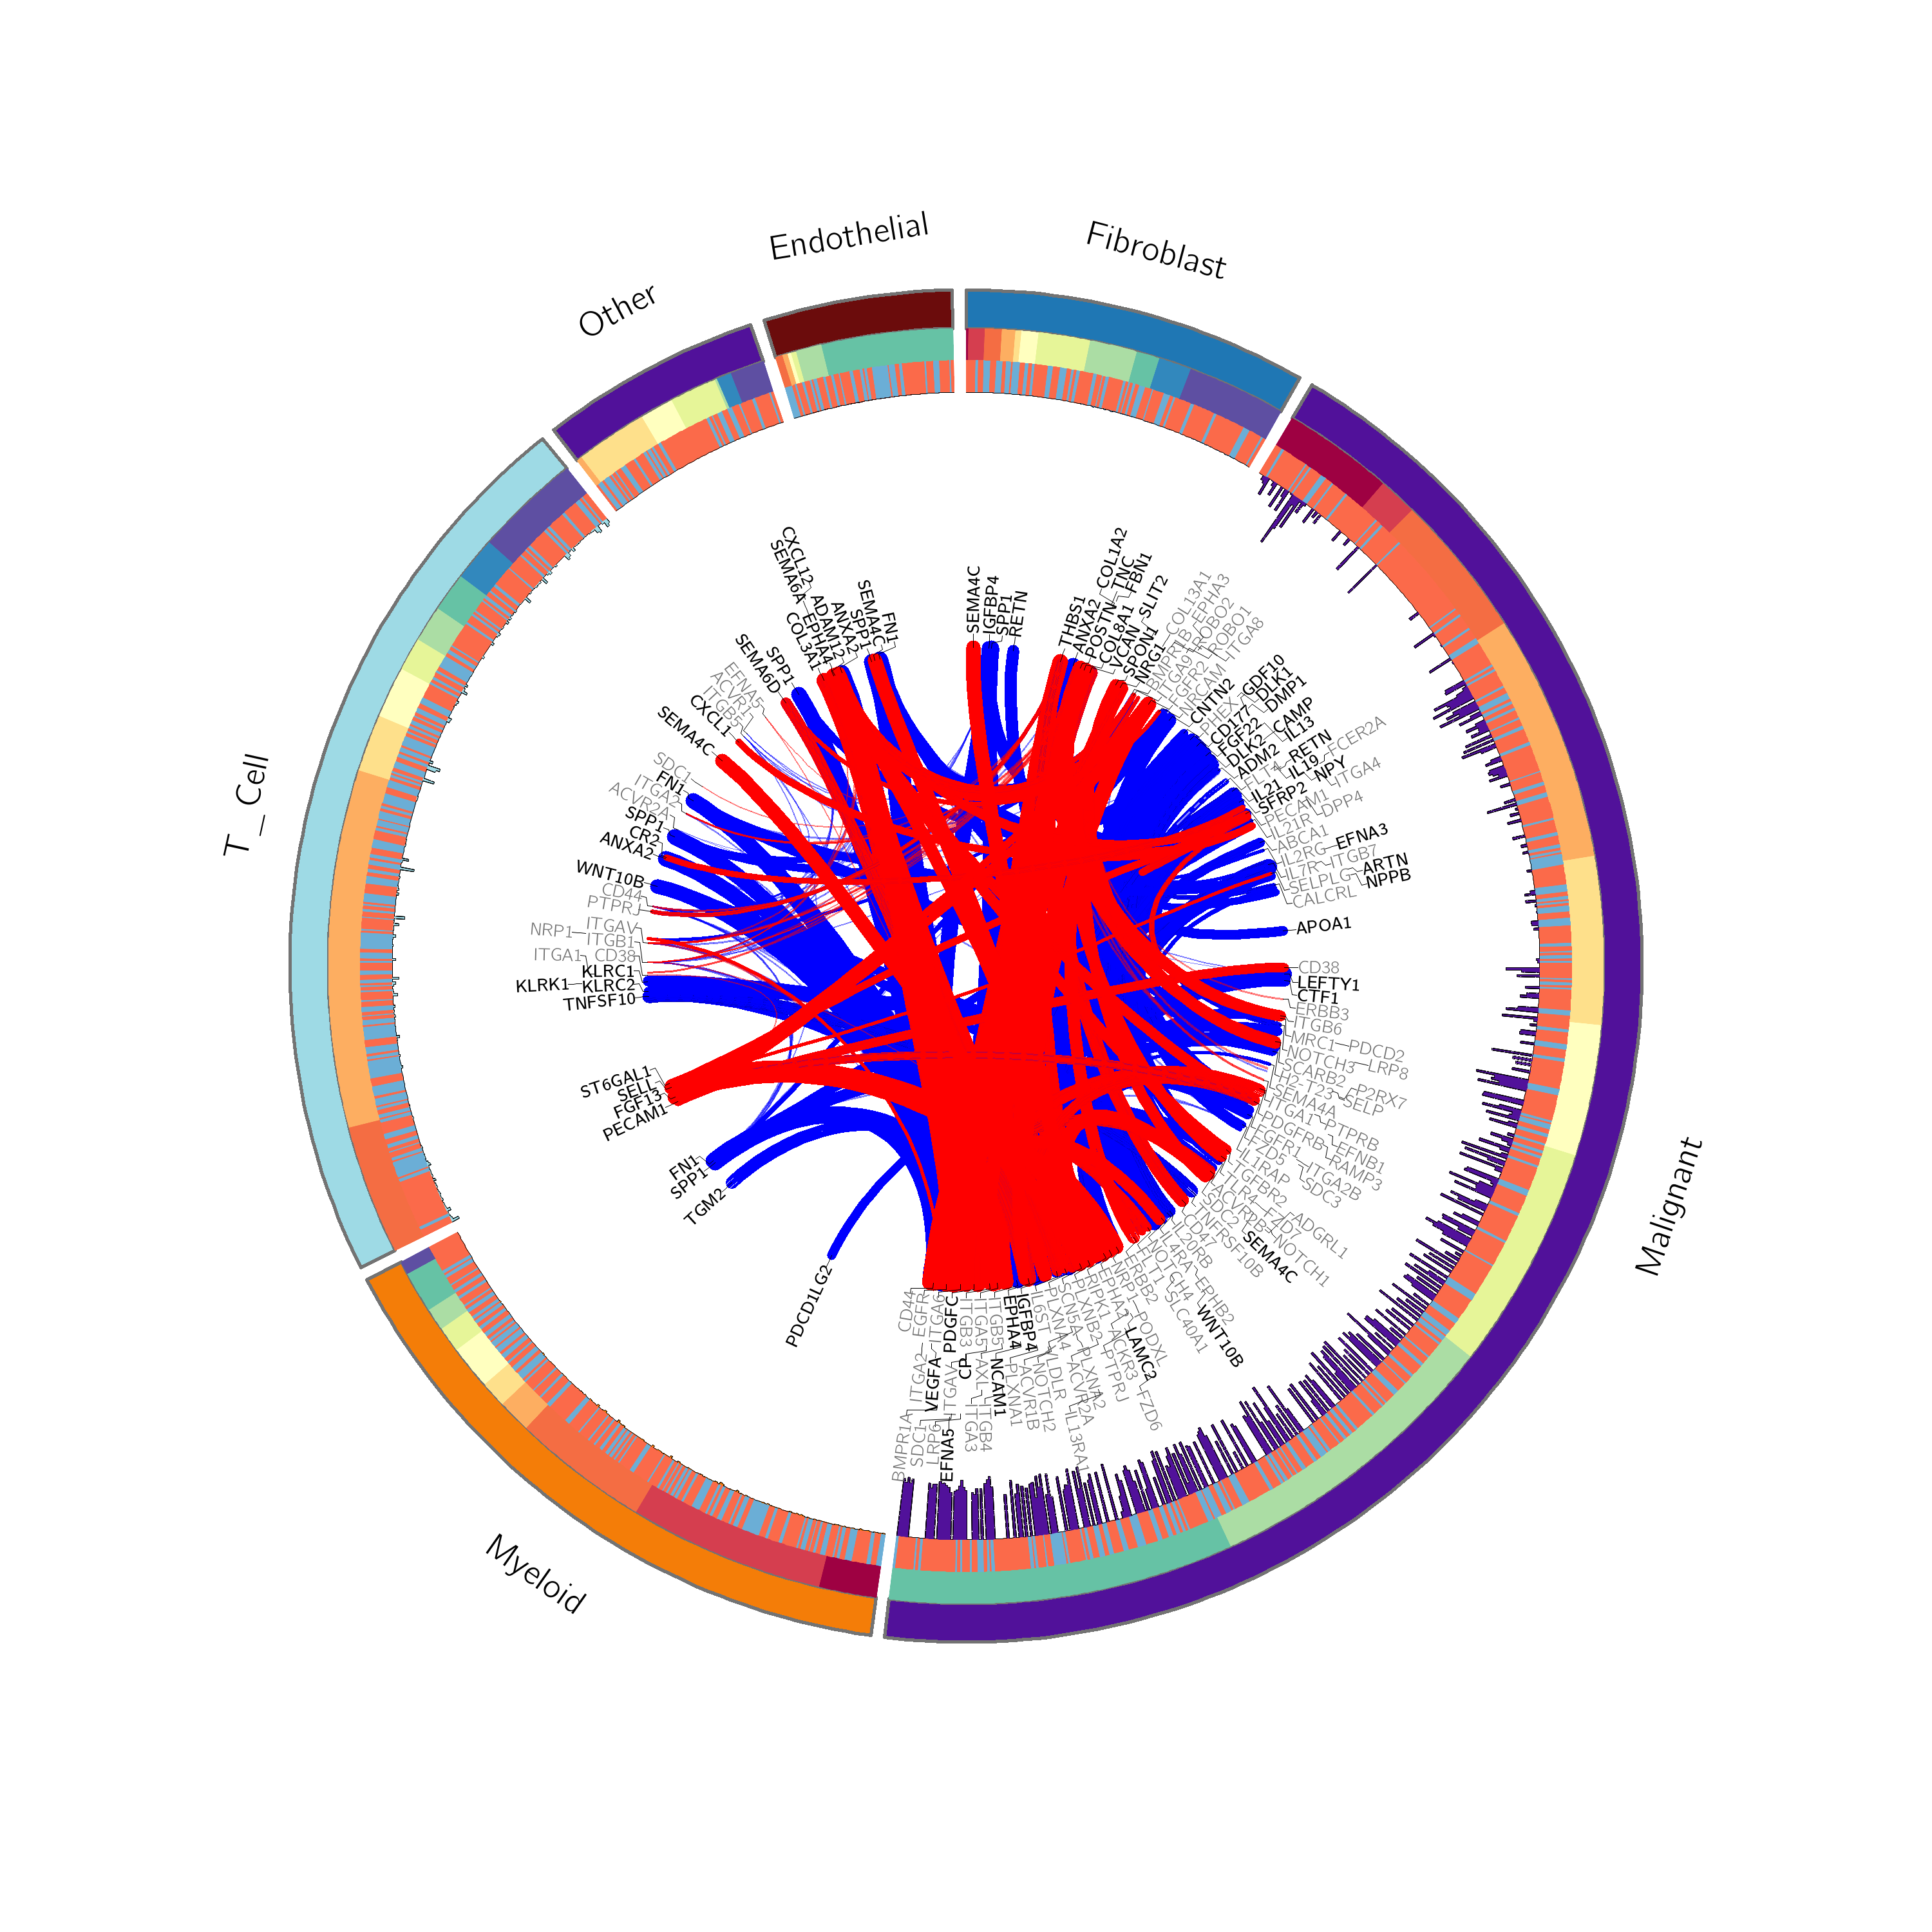

In [173]:
Image(f'{outdir}/circos.png')


In [13]:
merged_df

,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,logFC_column
0,0,B_Cell,A,0.008696,-17.075854,-1.415255,-0.986545,8449.3960,0.019212,0.0,False,True,NaN,NaN,-1.0
1,1,Fibroblast,A,0.057546,2.095785,0.004226,0.568209,4399.7310,0.010004,0.0,False,True,-0.097350,5.896072e-03,1.0
2,2,Malignant,A,0.043446,-6.533803,1.576831,-0.656555,19440.6400,0.044203,0.0,False,True,-0.057787,1.745306e-36,1.0
3,3,Pericytes,A,0.186992,2.023620,-3.537948,0.162502,2206.9937,0.005018,0.0,False,True,NaN,NaN,-1.0
4,4,Fibroblast,ABCA1,0.294245,1.400343,-0.020715,0.379661,4480.7560,0.010188,3.0,True,False,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2374,T_Cell,XPR1,0.332738,-1.680566,0.538532,-0.456826,2034.3727,0.004626,0.0,False,True,-0.103414,4.654219e-07,-1.0
2375,2375,Endothelial,ZNRF3,0.153086,1.490667,0.588101,0.525855,4641.6720,0.010554,2.0,True,False,NaN,NaN,1.0
2376,2376,Malignant,ZNRF3,0.347056,5.687575,1.694045,0.571521,266740.1600,0.606496,3858.0,True,False,NaN,NaN,1.0
2377,2377,Myeloid,ZNRF3,0.203615,-3.099748,0.637408,-0.832227,9274.0060,0.021087,44.0,True,False,NaN,NaN,1.0


In [15]:

#This function saves the plot in the circos folder in the defined output folder
#any errors is saved to this folder as well in the circos_stdout.txt file
outdir=f'{output_dir}/circos_edited'
cellType_colormap = {
    'B_cells':'#F9D318', 'Endothelial': '#6B0C0C', 'Fibroblasts':'#216C04',
                     'Malignant': '#51119A', 'Myeloid': '#F47D08','T_cells':'#A4D10A','Other':'#51119A'
}
tmp = ct.make_circos_plot(interactions,
                          merged_df,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=200,
                          links_max_ligand_fdr=0.0007,
                          links_min_ligand_absLog2FC=0.5,
                          #heatmap_plots=['cell_type_dc1_norm'],
                          heatmap_plots=['cell_type_dc1_norm', 'logFC_column'],
                          heatmap_cmaps={'logFC_column':  'hue240,hue000'},
                          order_col='cell_type_dc1_norm',
                          outdir=outdir,
                          colorMap=cellType_colormap,
                          cellType_labels=True)



Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 1734
 num_receptor = 757
Removing 2 cell Types that have no labels: Pericytes,B_Cell
target_stats.shape = (1503, 17)
No color assigned for Fibroblast, assigning random color
No color assigned for T_Cell, assigning random color
Malignant 665
T_Cell 331
Myeloid 231
Fibroblast 126
Other 81
Endothelial 69
Wrote karyotype file with 6 chromosomes and 1503 genes
Number of links: : 343
Wrote ../ZachData//circos_edited/circos.conf
Done making circos plot {outdir}/circos.png


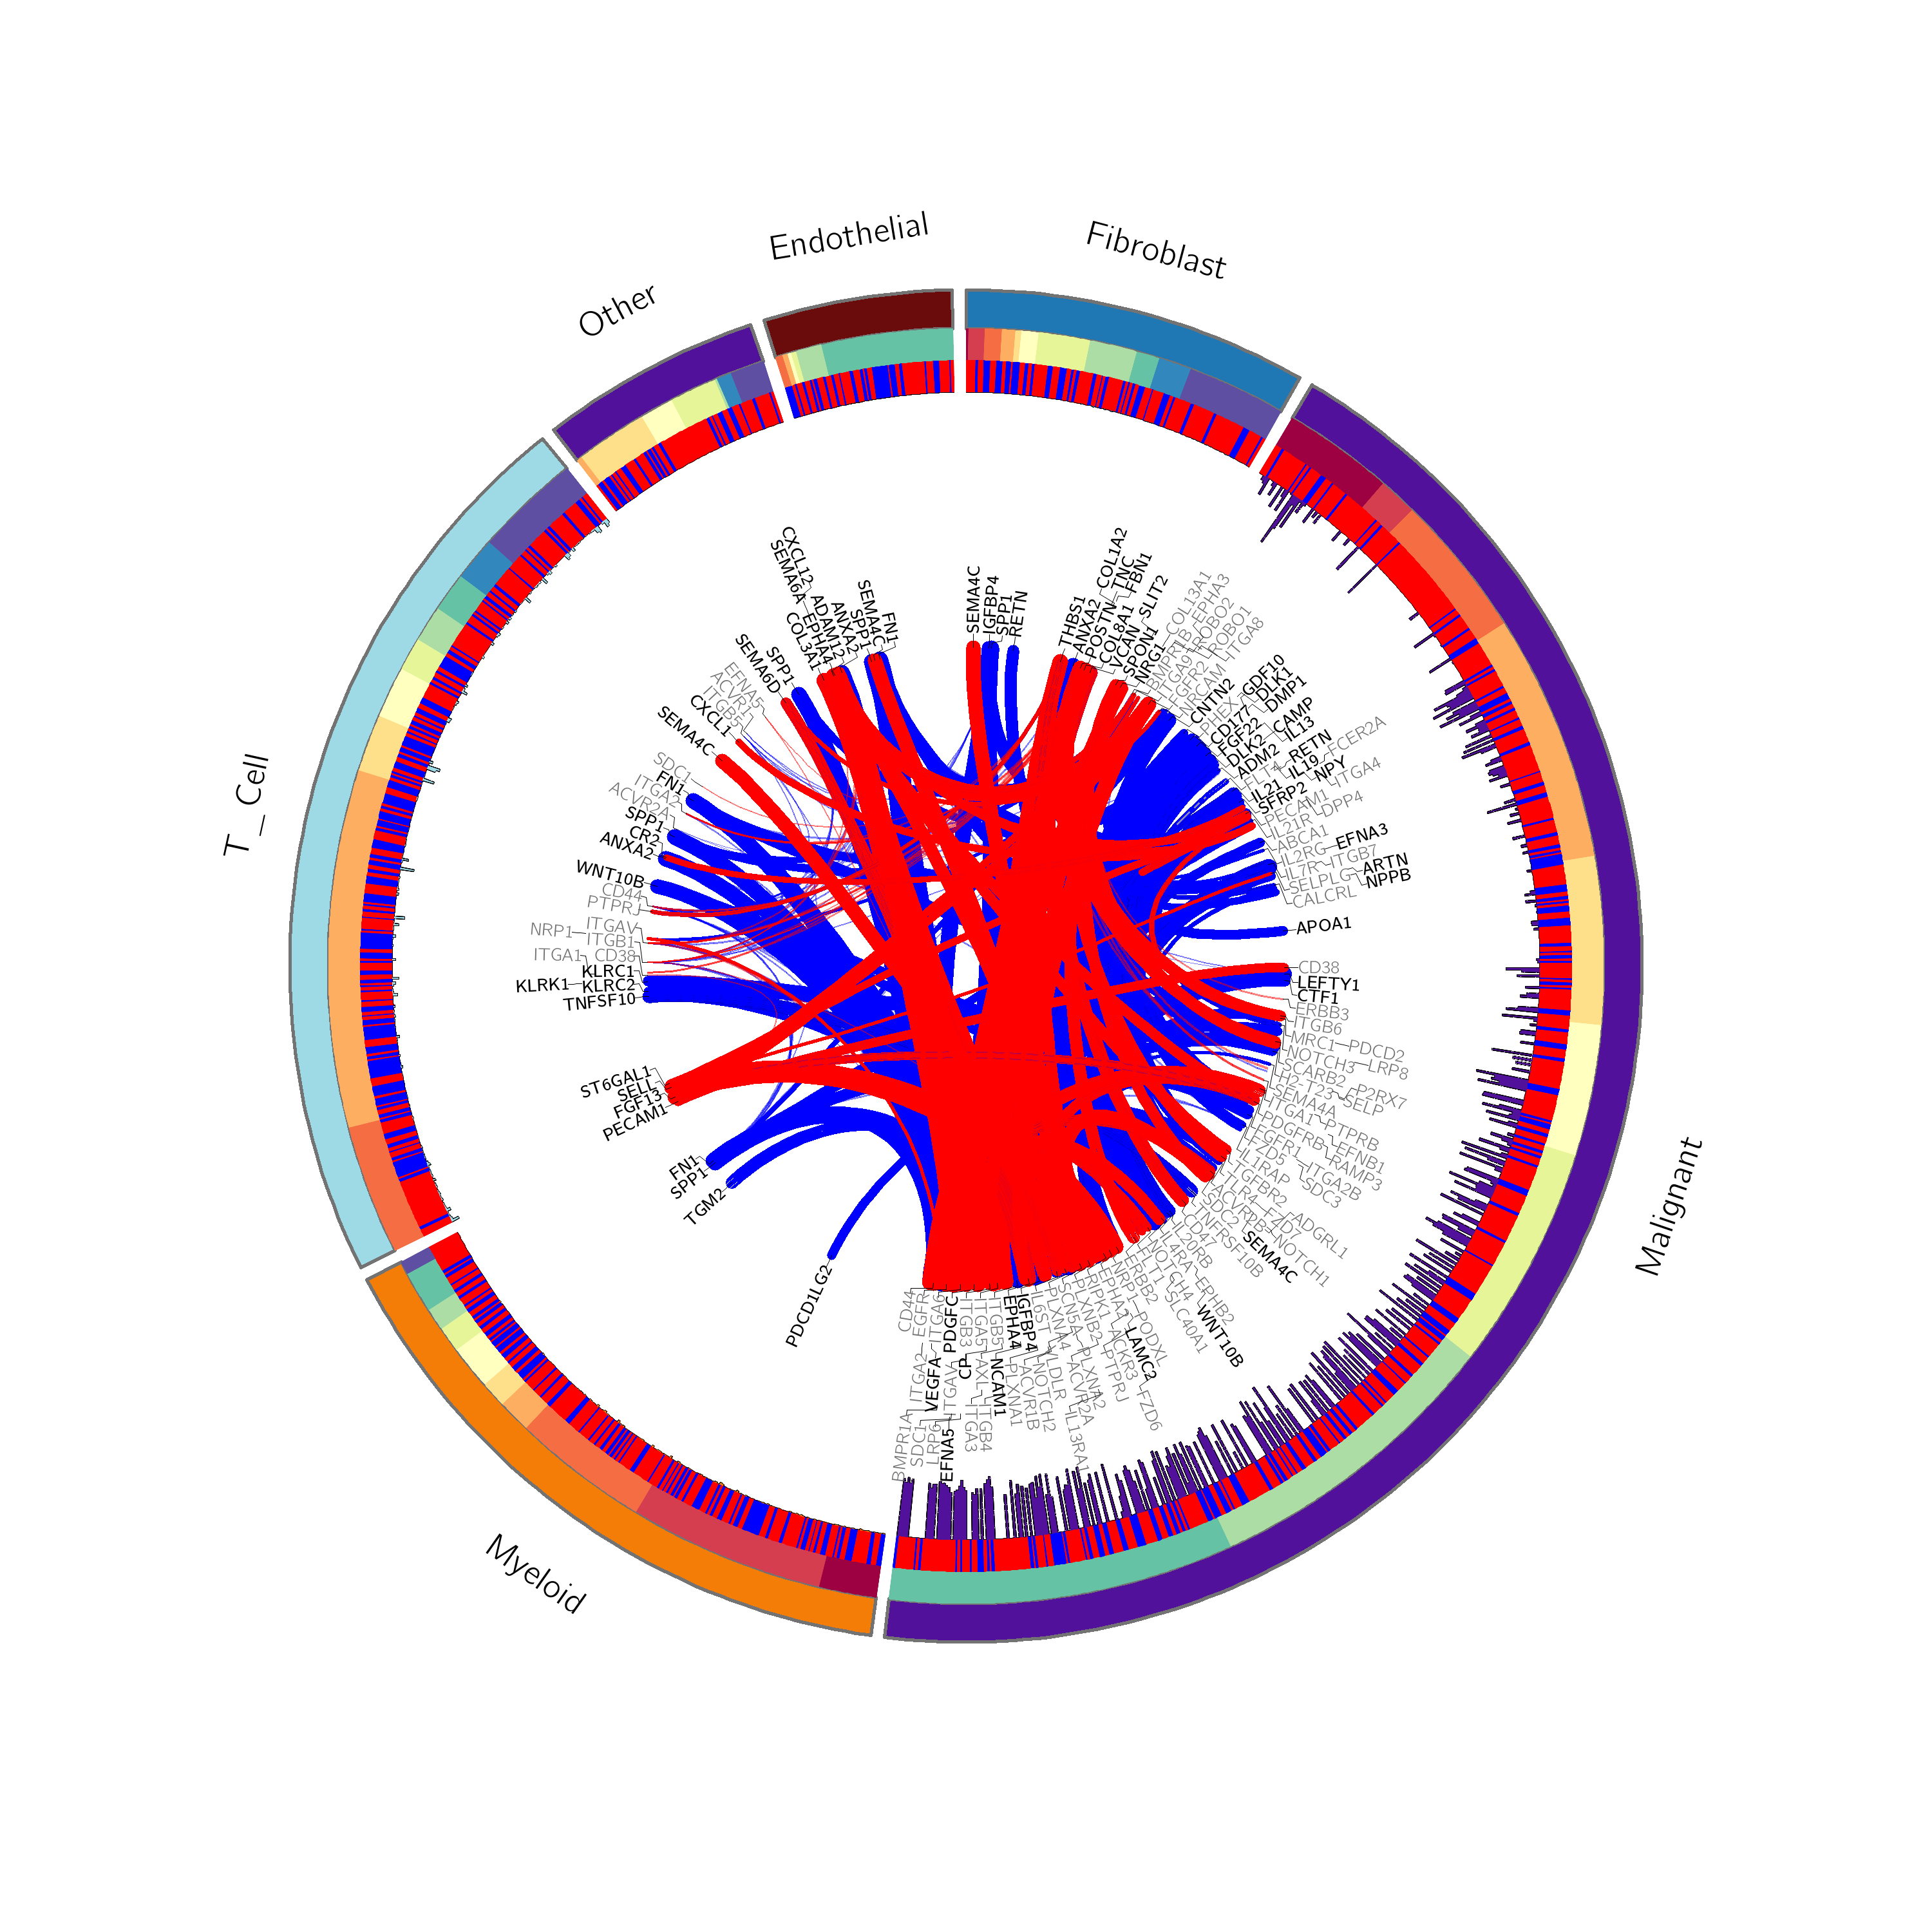

In [16]:
Image(f'{outdir}/circos.png')


In [101]:
interactions_df[(interactions_df['ligand'] == "VIM") &(interactions_df['cell_type_ligand'] == "Myeloid")]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
72,VIM,Myeloid,CD44,Malignant,-0.374281,3.043886e-13,True,4962
2151,VIM,Myeloid,CD44,T_Cell,-0.374281,3.043886e-13,True,555
3466,VIM,Myeloid,CD44,Myeloid,-0.374281,3.043886e-13,True,50
7611,VIM,Myeloid,CD44,Fibroblast,-0.374281,3.043886e-13,True,0
7612,VIM,Myeloid,CD44,Endothelial,-0.374281,3.043886e-13,True,0


In [105]:
interactions_df[(interactions_df['ligand'] == "C3") &(interactions_df['cell_type_ligand'] == "Myeloid")]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
638,C3,Myeloid,LRP1,Malignant,-0.208199,0.000001,True,4442
809,C3,Myeloid,CD81,Malignant,-0.208199,0.000001,True,4210
1570,C3,Myeloid,CD46,Malignant,-0.208199,0.000001,True,2351
1686,C3,Myeloid,CR2,Malignant,-0.208199,0.000001,True,1963
2032,C3,Myeloid,CD55,Malignant,-0.208199,0.000001,True,861
2218,C3,Myeloid,ITGB2,Malignant,-0.208199,0.000001,True,500
2321,C3,Myeloid,CD19,Malignant,-0.208199,0.000001,True,456
2608,C3,Myeloid,ITGAM,Malignant,-0.208199,0.000001,True,203
2679,C3,Myeloid,ITGB2,Myeloid,-0.208199,0.000001,True,173
2914,C3,Myeloid,LRP1,T_Cell,-0.208199,0.000001,True,122


In [120]:
interactions_df[(interactions_df['ligand'] == "CD47") &(interactions_df['cell_type_ligand'] == "Myeloid")]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
2246,CD47,Myeloid,SIRPA,Malignant,-0.238504,0.000756,True,487
3864,CD47,Myeloid,SIRPA,Myeloid,-0.238504,0.000756,True,27
4565,CD47,Myeloid,SIRPA,Endothelial,-0.238504,0.000756,True,7
5642,CD47,Myeloid,SIRPA,Fibroblast,-0.238504,0.000756,True,1
9692,CD47,Myeloid,SIRPA,T_Cell,-0.238504,0.000756,True,0


In [119]:
interactions_df[(interactions_df['ligand'] == "CD74") &(interactions_df['cell_type_ligand'] == "Myeloid")]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
366,CD74,Myeloid,APP,Malignant,-0.453934,1.696341e-12,True,4682
3732,CD74,Myeloid,APP,T_Cell,-0.453934,1.696341e-12,True,35
5214,CD74,Myeloid,APP,Myeloid,-0.453934,1.696341e-12,True,2
9974,CD74,Myeloid,APP,Fibroblast,-0.453934,1.696341e-12,True,0
9975,CD74,Myeloid,APP,Endothelial,-0.453934,1.696341e-12,True,0


In [27]:
#this cell makes the output data you request
#Make sure that the filters here align with the filters from the above function
#certain varibales are used to filter ligands (fdr for instance)
#certain variables are used to filter receptors (numSigI1_fdr05 for instance)


def target_strats_filters(row):
    if (row["receptor"]  == "True" and abs(row["numSigI1_fdr05"]) > 25):
        return True
    elif (row["receptor"]  == "True"):
        return False
    if (abs(row["fdr"]) < 0.05):
        return True
    return False

target_stats =target_stats[ target_stats.apply(lambda x: target_strats_filters(x), axis  =1)]
target_stats


new_pairs = []
for i,x in interactions.iterrows():
    ligands = target_stats[target_stats["target"] == x["ligand"]]
    receptors = target_stats[target_stats["target"] == x["receptor"]]
    for j,y in ligands.iterrows():
        for k,z in receptors.iterrows():
            new_pairs.append([ x["ligand"], x["receptor"], y["cell type"], z["cell type"], y["log2FC"], 
                            y['fdr'], y['absDE_scaled'], z['absDE_scaled'], y['numSigI1_fdr05'], z['numSigI1_fdr05'],
                              y['cell_type_dc1'], z['cell_type_dc2']
                             ])
df = pd.DataFrame(new_pairs, columns = ["ligand", "receptor", "ligand_t", "receptor_t", "log2Fc",
                                       "fdr", "ligand de", "receptor de", "ligand numSig", "receptor numSig", "dc1", "dc2"]  )


In [28]:
df.to_csv(f'{outdir}/circos_interactions.csv', index = None)

'../ContactTracingOutput/circos/circos.png'